# Reviews Analysis

A dataset of 5000 movies was collected from [Kaggle](https://www.kaggle.com/tmdb/tmdb-movie-metadata#tmdb_5000_movies.csv). This data contains film information such as budget, revenue, popularity, average vote rating. Using this data we can perform regression analysis to predict the **'success labels'** of a film. We can also begin to classify the movies based on their rating.

The predominant motivation behind the **Reviews Analysis** notebook is to define a benchmark for the success outcomes of the films within our dataset. We will use the benchmark to gain an understanding on the effectiveness of the predictive models created for the **Films Analysis** notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn                   import linear_model, ensemble, preprocessing
from sklearn.model_selection   import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics           import r2_score, mean_squared_error, accuracy_score
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.naive_bayes       import MultinomialNB, GaussianNB

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 6
%matplotlib inline

In [2]:
df = pd.read_csv('../data/tmdb_5000_movies.csv', parse_dates=["release_date"])

print("count:", len(df))
df.head()

count: 4803


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


## Cleaning the Dataset ##

As seen above the dataset contains a number of fields we will not require for our analysis. These include things like overview, language, runtime etc. To simplify the dataset we will remove these. To ensure a reasonable sample, we will also only include movies with over 2000 votes as films with fewer votes were found to produce much skewed results.

In [3]:
movies = df[['budget', 'popularity', 'release_date', 'revenue', 'tagline', 'title', 'vote_average', 'vote_count']].copy()
movies['profit'] = movies['revenue'] - movies['budget']

# Only count movies with over 2000 votes
movies = movies.loc[movies['vote_count'] >= 2000]

print("count:", len(movies))
movies.head()

count: 433


,budget,popularity,release_date,revenue,tagline,title,vote_average,vote_count,profit
0,237000000,150.437577,2009-12-10,2787965087,Enter the World of Pandora.,Avatar,7.2,11800,2550965087
1,300000000,139.082615,2007-05-19,961000000,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,661000000
2,245000000,107.376788,2015-10-26,880674609,A Plan No One Escapes,Spectre,6.3,4466,635674609
3,250000000,112.312950,2012-07-16,1084939099,The Legend Ends,The Dark Knight Rises,7.6,9106,834939099
4,260000000,43.926995,2012-03-07,284139100,"Lost in our world, found in another.",John Carter,6.1,2124,24139100


### Observations ###

We can expect to see a rise in budget for films over time.

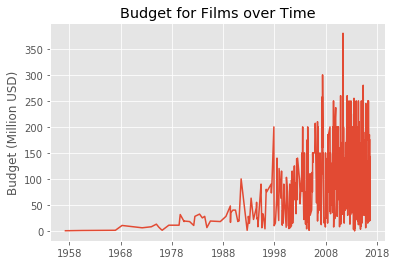

In [4]:
sorted_movies = movies.sort_values(by='release_date')

plt.plot(sorted_movies.release_date, sorted_movies.budget / 10**6)
plt.title("Budget for Films over Time")
plt.ylabel("Budget (Million USD)")
plt.show()

## Correlations ##

Using a pairplot and the correlations function in pandas we can gain an overview of the correlations between features in the dataset.

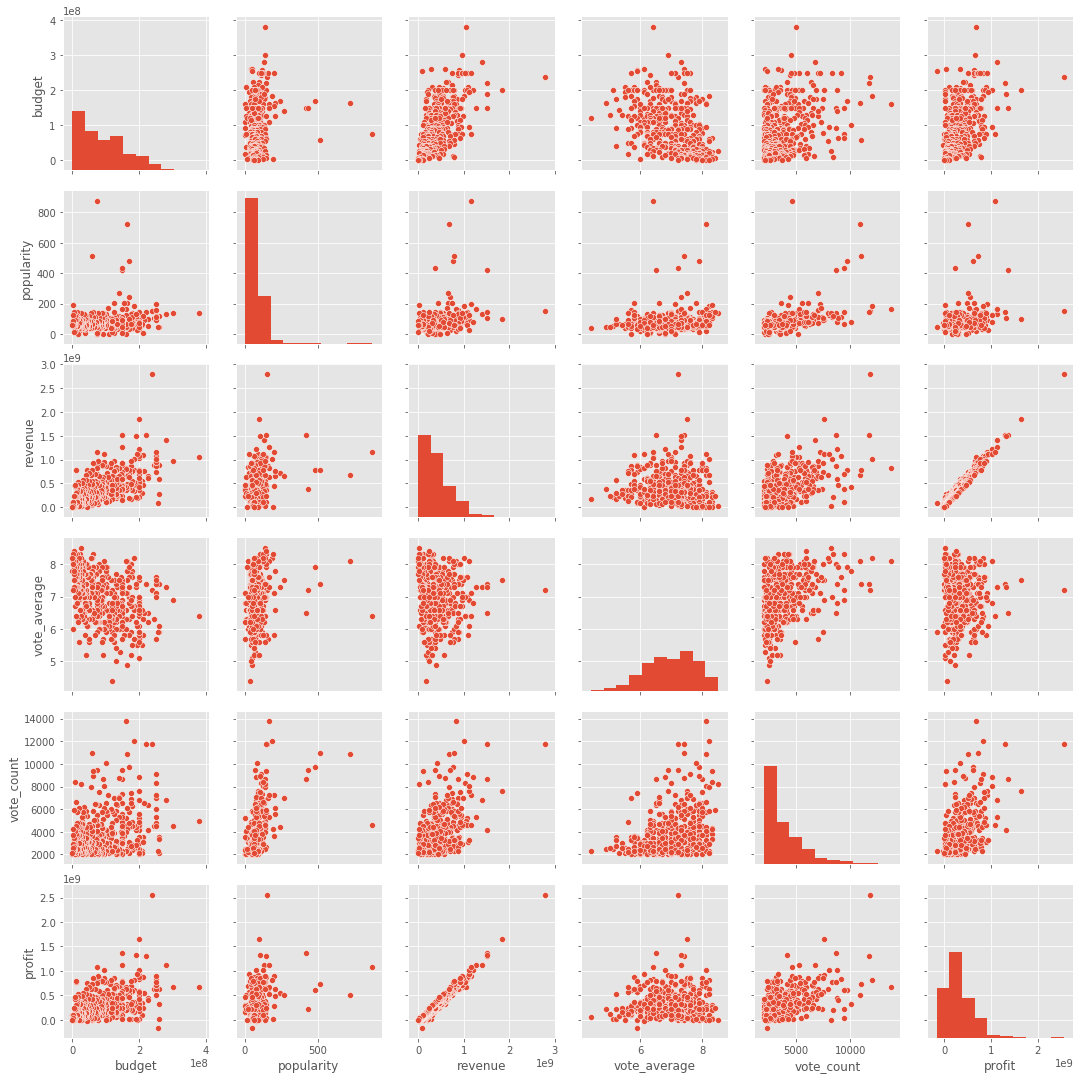

In [5]:
sns.pairplot(movies)
plt.show()

In [6]:
corrs = movies.corr()
corrs

,budget,popularity,revenue,vote_average,vote_count,profit
budget,1.000000,0.164061,0.640682,-0.386820,0.296033,0.487170
popularity,0.164061,1.000000,0.329555,0.135857,0.498952,0.335210
revenue,0.640682,0.329555,1.000000,-0.079467,0.536487,0.982652
vote_average,-0.386820,0.135857,-0.079467,1.000000,0.360261,0.003048
vote_count,0.296033,0.498952,0.536487,0.360261,1.000000,0.538698
profit,0.487170,0.335210,0.982652,0.003048,0.538698,1.000000


As expected we can see strong correlations between monetary metrics (such as budget and revenue).

## Linear Regression

Using the information from the above pair plot and correlations we can use a linear regression algorithm to determine whether we can predict ‘Vote Average’ from the other features.

We will need to remove all features that are categorical.

In [7]:
movies_set = movies.drop(columns=['tagline', 'title', 'release_date'])

X_train, X_test, y_train, y_test = train_test_split(movies_set.drop(columns=['vote_average']), movies_set['vote_average'], 
                                                    test_size=0.2, random_state=42)

In [8]:
reg = linear_model.LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
score = r2_score(y_test, y_pred)

print("MSE: %.2f" % mse)
print("R Squared: %.2f%%" % (score * 100))

MSE: 0.36
R Squared: 34.54%


## Predicting For Specific Movies ##

Using the linear regression model we can make predictions for the Voter Average based on metrics within the dataset. We can test our model on a subset of films within our data.

In [9]:
for title in ["Die Hard", "Avatar", "Star Wars", "Jurassic Park"]:
    film = movies.loc[movies['title'] == title]
    
    true = film.vote_average.values[0]
    pred = reg.predict(film[['budget', 'popularity', 'revenue', 'vote_count', 'profit']])[0]
    delta = pred - true
    
    print("film:".ljust(15), title)
    print('predicted:'.ljust(16), "%.1f" % pred)
    print('true:'.ljust(16), true)
    print('delta'.ljust(15), "%+.1f" % delta)
    print("-" * 40)

film:           Die Hard
predicted:       7.4
true:            7.5
delta           -0.1
----------------------------------------
film:           Avatar
predicted:       7.9
true:            7.2
delta           +0.7
----------------------------------------
film:           Star Wars
predicted:       8.1
true:            8.1
delta           -0.0
----------------------------------------
film:           Jurassic Park
predicted:       7.4
true:            7.6
delta           -0.2
----------------------------------------


## Other Regression Algorithms

The linear regression algorithm is a good indicator for whether there are potential correlations. Other regression algorithms can yield more accurate results than linear regressions.

### Random Forest Regressor

In [10]:
reg = ensemble.RandomForestRegressor(n_estimators=250).fit(X_train, y_train)
y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE: %.2f" % mse)
print("R Squared: %.2f%%" % (r2 * 100))

MSE: 0.25
R Squared: 55.35%


### Gradient Boosting Regressor

In [11]:
reg = ensemble.GradientBoostingRegressor().fit(X_train, y_train)
y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE: %.2f" % mse)
print("R Squared: %.2f%%" % (r2 * 100))

MSE: 0.28
R Squared: 48.48%


## RFE Feature Selection

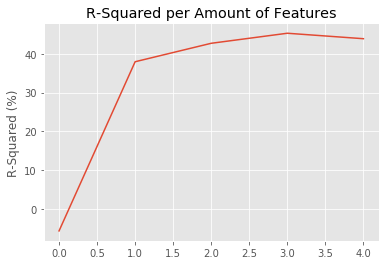

In [12]:
X_train, X_test, y_train, y_test = train_test_split(movies_set.drop(columns=['vote_average']), movies_set['vote_average'], 
                                                    test_size=0.33, random_state=42)
scores  = []
for n in range(1, X_train.shape[-1] +1 ):
    reg = ensemble.GradientBoostingRegressor()

    selector = RFE(reg, n).fit(X_train, y_train)
    y_pred = selector.predict(X_test)
    
    scores.append(r2_score(y_test, y_pred))

scores_df = pd.DataFrame(scores)

plt.plot(scores_df * 100)
plt.title("R-Squared per Amount of Features")
plt.ylabel("R-Squared (%)")
plt.show()

## Classification

To classify each film we will create a grading score outlined in the 'categorize' table below.

In [13]:
def categorize(n):
    if   n >= 7.0: return "A"
    elif n >= 6.5: return "B"
    elif n >= 6.0: return "C"
    else:          return "D"
    
movies['category'] = movies.vote_average.apply(categorize)
movies.head()

,budget,popularity,release_date,revenue,tagline,title,vote_average,vote_count,profit,category
0,237000000,150.437577,2009-12-10,2787965087,Enter the World of Pandora.,Avatar,7.2,11800,2550965087,A
1,300000000,139.082615,2007-05-19,961000000,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,661000000,B
2,245000000,107.376788,2015-10-26,880674609,A Plan No One Escapes,Spectre,6.3,4466,635674609,C
3,250000000,112.312950,2012-07-16,1084939099,The Legend Ends,The Dark Knight Rises,7.6,9106,834939099,A
4,260000000,43.926995,2012-03-07,284139100,"Lost in our world, found in another.",John Carter,6.1,2124,24139100,C


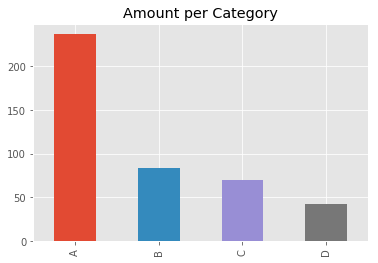

In [14]:
movies['category'].value_counts().plot.bar()

plt.title("Amount per Category")
plt.show()

### Resampling ###

Inorder to balance our dataset we will resample our distrobutions of each label to 100.

In [15]:
count = 100

A = movies.loc[movies['category'] == 'A'].sample(count, replace=True)
B = movies.loc[movies['category'] == 'B'].sample(count, replace=True)
C = movies.loc[movies['category'] == 'C'].sample(count, replace=True)
D = movies.loc[movies['category'] == 'D'].sample(count, replace=True)

movies = pd.concat([A, B, C, D], axis=0)
movies.head()

,budget,popularity,release_date,revenue,tagline,title,vote_average,vote_count,profit,category
2403,18500000,67.660940,1986-07-18,183316455,This Time It's War,Aliens,7.7,3220,164816455,A
3454,6000000,64.025031,1995-07-19,23341568,Five Criminals. One Line Up. No Coincidence.,The Usual Suspects,8.1,3254,17341568,A
2607,15000000,49.230089,1998-03-06,46189568,Times like these call for a Big Lebowski.,The Big Lebowski,7.8,2926,31189568,A
744,60000000,59.547928,2014-02-06,469160692,The story of a nobody who saved everybody.,The Lego Movie,7.5,3070,409160692,A
899,60000000,67.298732,2001-05-16,484409218,The greatest fairy tale never told.,Shrek,7.3,4056,424409218,A


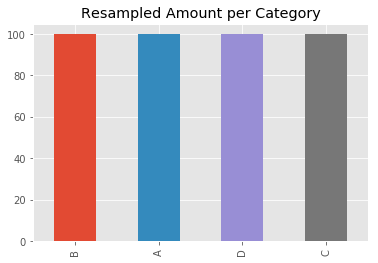

In [16]:
movies['category'].value_counts().plot.bar()

plt.title("Resampled Amount per Category")
plt.show()

### KNN Classifier

The KNN classifer will be used to attempt predicting movies category, based on popularity, budget, revenue and profit.

In [17]:
movies_set = movies.drop(columns=['title', 'tagline', 'release_date', 'vote_average'])

X_train, X_test, y_train, y_test = train_test_split(movies_set.drop(columns=['category']), movies_set['category'], 
                                                    test_size=0.33, random_state=42)
X_train.head()

,budget,popularity,revenue,vote_count,profit
52,195000000,28.529607,1123746996,3299,928746996
99,38000000,6.909942,207283925,3428,169283925
1340,37000000,100.348805,269994119,2972,232994119
3263,8000000,45.395839,74952305,2210,66952305
150,140000000,91.332849,441818803,3114,301818803


In [18]:
clf = KNeighborsClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("KNeighbours Classifier - Accuracy: %.2f%%" % (accuracy * 100))

KNeighbours Classifier - Accuracy: 45.45%


### Naive Bayes

In [19]:
gnb = GaussianNB().fit(X_train, y_train)
y_pred = gnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Gaussian Naive Bayes Classifier - Accuracy: %.2f%%" % (accuracy * 100))

Gaussian Naive Bayes Classifier - Accuracy: 37.88%


### Discretizer

The KBinsDiscretizer turns continuous values into discrete bins.

In [20]:
est = preprocessing.KBinsDiscretizer(n_bins=10, encode='onehot', strategy='uniform')

X = est.fit_transform(movies_set.drop(columns=['category'])).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, movies_set['category'], 
                                                    test_size=0.33, random_state=42)


mnb = MultinomialNB().fit(X_train, y_train)
y_pred = mnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Multinomial Naive Bayes Classifier - Accuracy: %.2f%%" % (accuracy * 100))

Multinomial Naive Bayes Classifier - Accuracy: 47.73%


## Conclusion ##

We can observe a variety of approaches we can use to create a predictive model. We have identified **Random Forest Regressor** to be the most accurate model given the data we are using, we are fortunate that the **Reviews Data** contains numerical features of which we can use as predictors. We will use this model as a benchmark of accuracy when creating the predictive model in the **Films Analysis** notebook, in which our predictors will be entirely categorical in nature.